# Linear Variational Auto Encoder
This notebook demonstrates the training of a Linear Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses, with BCE loss for reconstruction.

In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.simple_vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl


python(6472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 55218.48it/s]

Data filtered. Kept 34 models
Creating NaN mask...



100%|██████████| 34/34 [00:01<00:00, 17.17it/s]

NaN mask created.
Masking out NaN values...



100%|██████████| 34/34 [00:02<00:00, 16.46it/s]

NaN values masked out.
Reshaping data...



100%|██████████| 34/34 [00:04<00:00,  7.86it/s]

Data reshaped.
Adding the forced response to the data...



100%|██████████| 34/34 [00:04<00:00,  8.22it/s]

Forced response added.
Removing NaN values from the grid...



100%|██████████| 34/34 [00:02<00:00, 11.71it/s]

NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 34
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_6461/288037787.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2']
Testing model: ACCESS-ESM1-5


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

Data normalization completed.


In [7]:
# Create dataset for the linear VAE
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
batch_size = 16  # Higher batch size for linear VAE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

# Check the shape of the data
sample = next(iter(train_loader))
print(f"Input shape: {sample['input'].shape}")
print(f"Output shape: {sample['output'].shape}")

Creating datasets...


Processing models: 100%|██████████| 33/33 [00:00<00:00, 72504.99it/s]


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 564.28it/s]


Training dataset size: 677
Testing dataset size: 40
Input shape: torch.Size([16, 165, 6523])
Output shape: torch.Size([16, 165, 6523])


In [8]:
# Initialize the Linear VAE model
# Calculate input dimension from flattened sample
sample = next(iter(train_loader))
input_shape = sample['input'].shape[1:]
print(input_shape)
input_dims = (input_shape[0], input_shape[1])
assert isinstance(input_dims, tuple) and len(input_dims) == 2, "Input dimensions should be a tuple of length 2"
print(f"Input dimension for VAE: {input_dims}")

# Set VAE parameters
hidden_dim = 256  # Increased for better representation
latent_dim = 64   # Intermediate layer size
z_dim = 20       # Actual latent space dimension
# beta = 0.001      # Weight for KL divergence term -- not used in this version

# Create the model
# vae_model = SIMPLEVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device, z_dim=z_dim).to(device)
vae_model = SIMPLEVAE(input_dims, z_dim, device=device).to(device)

# Apply weight initialization
# vae_model.apply(initialize_weights)

# Print model summary
print("\nLinear VAE Model Architecture:")
print(vae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")

torch.Size([165, 6523])
Input dimension for VAE: (165, 6523)

Linear VAE Model Architecture:
SIMPLEVAE(
  (encoder): Sequential(
    (0): Linear(in_features=6523, out_features=20, bias=True)
  )
  (mean_layer): Linear(in_features=20, out_features=20, bias=True)
  (logvar_layer): Linear(in_features=20, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=6523, bias=True)
  )
)

Total parameters: 268,303


In [9]:
# Train the VAE
epochs = 100
losses = []

optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-4) # Weight decay is not used in this version (was weight_decay=1e-5)

losses = train_vae(vae_model, train_loader, optimizer, epochs=epochs, device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Training batch input shape: torch.Size([16, 165, 6523])
Training batch output shape: torch.Size([16, 165, 6523])


  1%|          | 1/100 [00:03<05:49,  3.53s/it]

Epoch 1, Average Loss: 494054.7504


 11%|█         | 11/100 [00:17<02:01,  1.36s/it]

Epoch 11, Average Loss: 61428.6939


 21%|██        | 21/100 [00:30<01:45,  1.33s/it]

Epoch 21, Average Loss: 23892.2079


 31%|███       | 31/100 [00:44<01:32,  1.34s/it]

Epoch 31, Average Loss: 22424.9297


 41%|████      | 41/100 [00:57<01:19,  1.34s/it]

Epoch 41, Average Loss: 21789.9193


 51%|█████     | 51/100 [01:10<01:06,  1.35s/it]

Epoch 51, Average Loss: 21172.5483


 61%|██████    | 61/100 [01:25<00:54,  1.39s/it]

Epoch 61, Average Loss: 20652.6021


 71%|███████   | 71/100 [01:39<00:40,  1.38s/it]

Epoch 71, Average Loss: 20426.7226


 81%|████████  | 81/100 [01:52<00:26,  1.37s/it]

Epoch 81, Average Loss: 20127.0484


 91%|█████████ | 91/100 [02:06<00:12,  1.34s/it]

Epoch 91, Average Loss: 19998.2659


100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


## Save the model

In [10]:
# Save the model
model_path = os.path.join('models', 'linear_vae_model.pth')
save_model(vae_model, model_path)

Model saved to models/linear_vae_model.pth


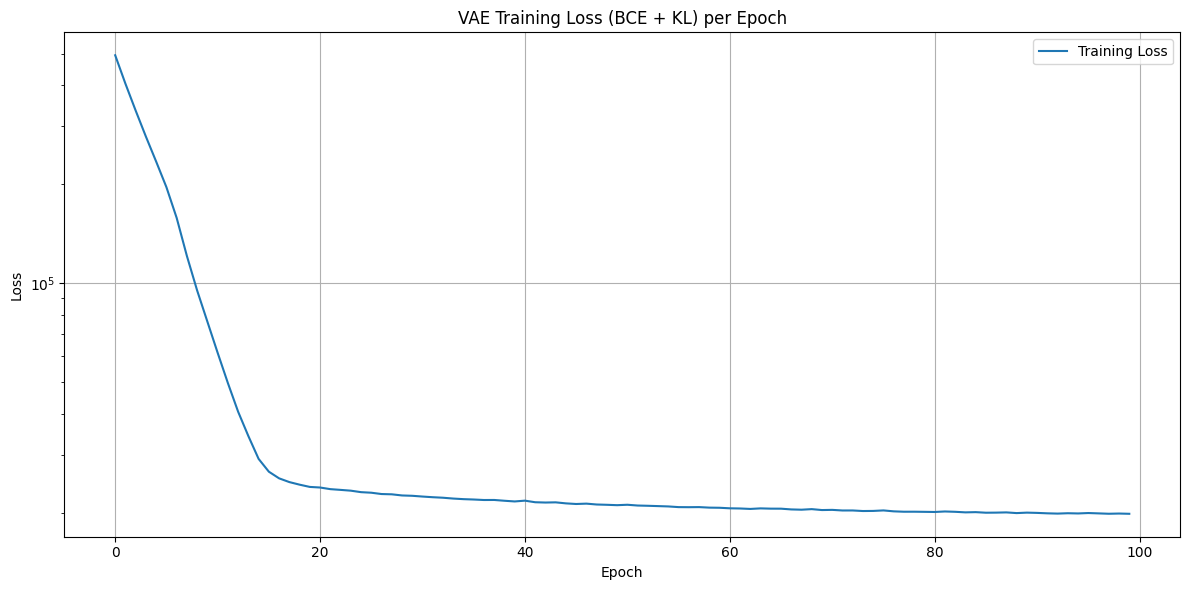

Final loss value: 19872.957366


In [11]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

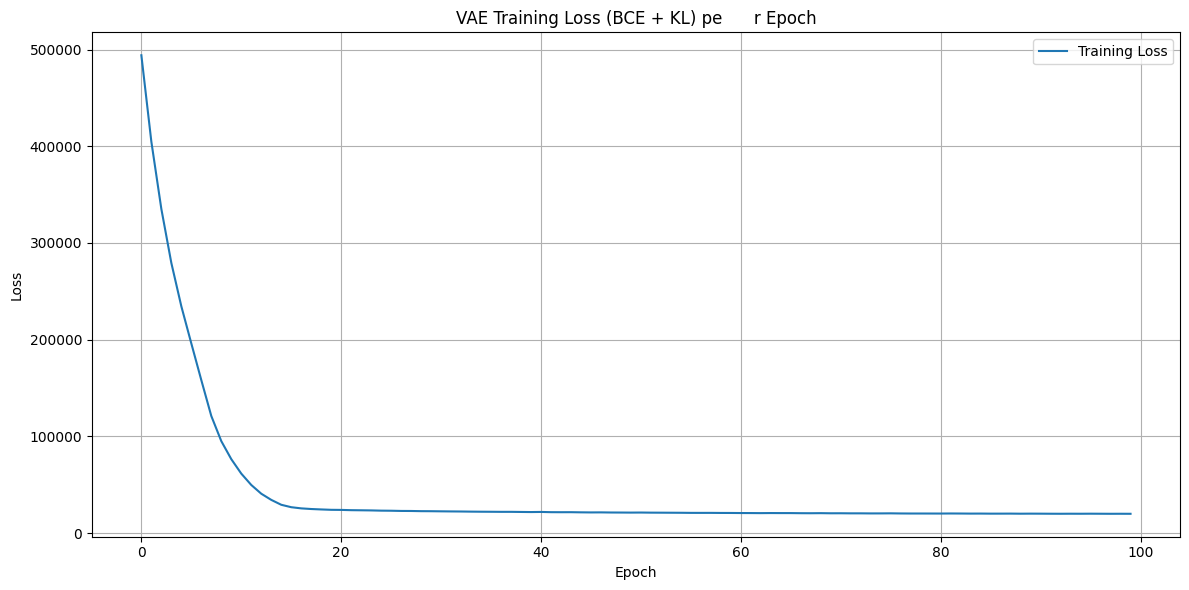

Final loss value: 19872.957366


In [12]:
# Plot the training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss (BCE + KL) pe      r Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.yscale('log')  # Using log scale to better visualize the decreasing loss
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.6f}")

# Random Run Selection and Inference
Now we'll select some random runs from the test model and use our trained VAE model to make predictions.

In [13]:
# Set the number of random runs to select
num_runs = 5

# Get the available runs for the test model (excluding forced_response)
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
print(f"Available runs for {test_model}: {test_runs}")

# Randomly select runs
if len(test_runs) > num_runs:
    selected_runs = random.sample(test_runs, num_runs)
else:
    selected_runs = test_runs
    
print(f"Selected runs for visualization: {selected_runs}")

Available runs for ACCESS-ESM1-5: ['r1i1p1f1', 'r3i1p1f1', 'r2i1p1f1', 'r4i1p1f1', 'r10i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r9i1p1f1', 'r8i1p1f1', 'r16i1p1f1', 'r17i1p1f1', 'r18i1p1f1', 'r14i1p1f1', 'r20i1p1f1', 'r15i1p1f1', 'r11i1p1f1', 'r19i1p1f1', 'r13i1p1f1', 'r12i1p1f1', 'r7i1p1f1', 'r21i1p1f1', 'r22i1p1f1', 'r23i1p1f1', 'r24i1p1f1', 'r25i1p1f1', 'r26i1p1f1', 'r27i1p1f1', 'r28i1p1f1', 'r29i1p1f1', 'r30i1p1f1', 'r31i1p1f1', 'r32i1p1f1', 'r33i1p1f1', 'r34i1p1f1', 'r35i1p1f1', 'r36i1p1f1', 'r37i1p1f1', 'r38i1p1f1', 'r39i1p1f1', 'r40i1p1f1']
Selected runs for visualization: ['r16i1p1f1', 'r20i1p1f1', 'r22i1p1f1', 'r6i1p1f1', 'r5i1p1f1']


In [14]:
# Set VAE to evaluation mode
vae_model.eval()

# Create a directory for saving animations if it doesn't exist
animation_dir = os.path.join('outputs', 'simple', 'vae')
os.makedirs(animation_dir, exist_ok=True)
print(f"Animations will be saved to: {animation_dir}")

# Get ground truth for the test model
ground_truth = normalized_test_data[test_model]['forced_response']

# Store predictions for visualization
predictions = {}
mse_values = {}

# Generate predictions for each selected run
for run in selected_runs:
    # Get the run data
    run_data = normalized_test_data[test_model][run] # Shape 165 x 6523
    
    # Convert to torch tensor
    input_tensor = torch.tensor(run_data, dtype=torch.float32).unsqueeze(0).to(device) # Shape 1076295 = input_dim
    print(f"Input tensor shape: {input_tensor.shape}")
    
    # Make prediction with the VAE
    with torch.no_grad():
        # Forward pass through the VAE
        reconstructed, mu, log_var = vae_model(input_tensor)
        prediction = reconstructed.reshape(165, 6523).cpu().numpy()
    
    # Store prediction
    predictions[run] = prediction  # Reshape to original dimensions
    
    # Calculate MSE
    mse = np.mean((prediction - ground_truth) ** 2)
    mse_values[run] = mse
    print(f"MSE for {test_model} - {run}: {mse:.4f}")

print(f"\nAverage MSE across all selected runs: {np.mean(list(mse_values.values())):.4f}")

Animations will be saved to: outputs/simple/vae
Input tensor shape: torch.Size([1, 165, 6523])
MSE for ACCESS-ESM1-5 - r16i1p1f1: 0.2336
Input tensor shape: torch.Size([1, 165, 6523])
MSE for ACCESS-ESM1-5 - r20i1p1f1: 0.2266
Input tensor shape: torch.Size([1, 165, 6523])
MSE for ACCESS-ESM1-5 - r22i1p1f1: 0.2268
Input tensor shape: torch.Size([1, 165, 6523])
MSE for ACCESS-ESM1-5 - r6i1p1f1: 0.2408
Input tensor shape: torch.Size([1, 165, 6523])
MSE for ACCESS-ESM1-5 - r5i1p1f1: 0.2214

Average MSE across all selected runs: 0.2298


In [15]:
# Find the color limits for consistent visualization
all_data = []

# Add ground truth data
ground_truth_with_nans = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
all_data.append(ground_truth_with_nans)

# Add input data and predictions
for run in selected_runs:
    # Input data
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    all_data.append(input_data)
    
    # Prediction
    prediction_with_nans = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    all_data.append(prediction_with_nans)

# Find the minimum and maximum values across all data
all_data_concatenated = np.concatenate([data.flatten() for data in all_data])
all_data_concatenated = all_data_concatenated[~np.isnan(all_data_concatenated)]
vmin, vmax = np.nanpercentile(all_data_concatenated, [2, 98])

print(f"Color limits for visualization: [{vmin:.2f}, {vmax:.2f}]")

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Color limits for visualization: [-0.72, 2.34]


In [ ]:
# Generate animations
for run in selected_runs:
    print(f"\nGenerating animations for {test_model} - {run}...")
    
    # Reshape data for animation
    input_data = readd_nans_to_grid(normalized_test_data[test_model][run], nan_mask, predictions=True)
    input_data = input_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    prediction_data = readd_nans_to_grid(predictions[run], nan_mask, predictions=True)
    prediction_data = prediction_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    ground_truth_data = readd_nans_to_grid(ground_truth, nan_mask, predictions=True)
    ground_truth_data = ground_truth_data.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    # Create animations
    save_path = animation_dir
    
    # Input animation
    input_animation = animate_data(
        input_data,
        title=f'Input: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(input_animation.to_html5_video()))
    input_animation.save(f"{save_path}/vae_input_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Prediction animation
    pred_animation = animate_data(
        prediction_data,
        title=f'VAE Prediction: {test_model} - {run} (MSE: {mse_values[run]:.2f})',
        interval=200,
        cmap='viridis',
        color_limits=(vmin, vmax)
    )
    display(HTML(pred_animation.to_html5_video()))
    pred_animation.save(f"{save_path}/vae_prediction_{test_model}_{run}.mp4", writer='ffmpeg', fps=15)
    
    # Ground truth animation (only once)
    if run == selected_runs[0]:
        gt_animation = animate_data(
            ground_truth_data,
            title=f'Ground Truth: {test_model}',
            interval=200,
            cmap='viridis',
            color_limits=(vmin, vmax)
        )
        display(HTML(gt_animation.to_html5_video()))
        gt_animation.save(f"{save_path}/vae_ground_truth_{test_model}.mp4", writer='ffmpeg', fps=15)
    
print(f"\nAll animations have been saved to {save_path}")


Generating animations for ACCESS-ESM1-5 - r16i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


python(6578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(6583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(6596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(6602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Generating animations for ACCESS-ESM1-5 - r20i1p1f1...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


python(6608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(6612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(6625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Performance Analysis
Let's analyze the performance of our VAE model by comparing the MSE across different runs.

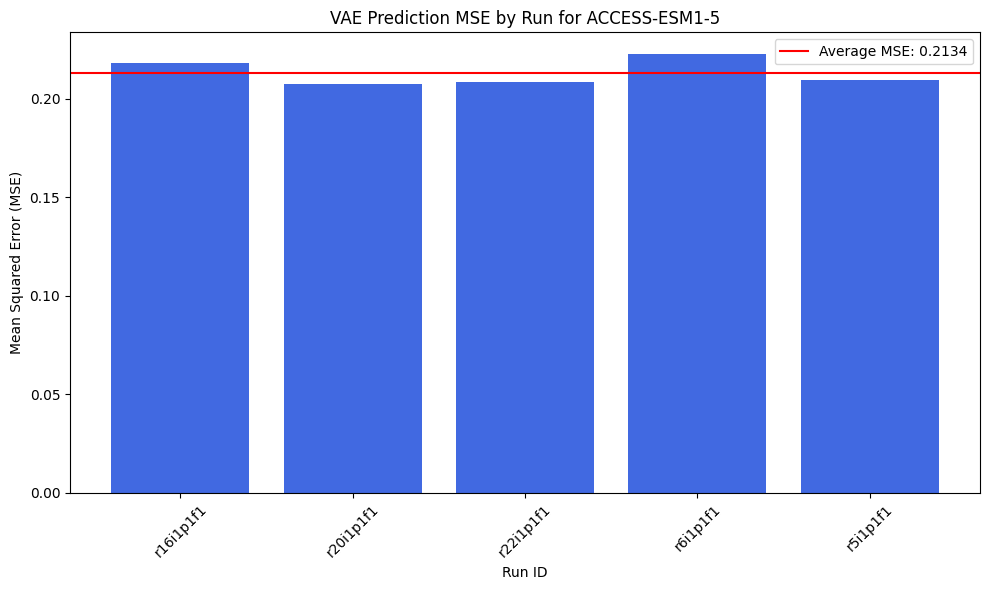

In [ ]:
# Plot MSE comparison
plt.figure(figsize=(10, 6))
runs = list(mse_values.keys())
mse_vals = list(mse_values.values())

plt.bar(runs, mse_vals, color='royalblue')
plt.axhline(y=np.mean(mse_vals), color='r', linestyle='-', label=f'Average MSE: {np.mean(mse_vals):.4f}')
plt.title(f'VAE Prediction MSE by Run for {test_model}')
plt.xlabel('Run ID')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{animation_dir}/vae_mse_comparison_{test_model}.png", dpi=300, bbox_inches='tight')
plt.show()

# Generate New Data Using Latent Space
In this section, we will utilize the latent space and decoder of the trained VAE model to generate new synthetic data.

In [ ]:
# Set the VAE model to evaluation mode
vae_model.eval()

# Number of samples to generate
num_samples = 5

# Generate new data
generated_data = vae_model.generate(num_samples).cpu().numpy()

print(f"Generated data shape: {generated_data.shape}")

# Reshape the generated data to the original dimensions - using correct attribute names
generated_data_reshaped = [data.reshape(vae_model.time_dim, vae_model.feature_dim) for data in generated_data]

# Create a directory for saving animations if it doesn't exist
animation_dir = os.path.join('outputs_vae_simple', 'animations', 'vae_generated')
os.makedirs(animation_dir, exist_ok=True)
print(f"Generated animations will be saved to: {animation_dir}")

# Generate animations for the sampled latent space outputs
for i, data in enumerate(generated_data_reshaped):
    print(f"\nGenerating animation for Generated Sample {i + 1}...")
    
    # Readd nans to grid
    data_with_nans = readd_nans_to_grid(data, nan_mask, predictions=True)
    data_with_nans = data_with_nans.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])
    
    # Create animation
    generated_animation = animate_data(
        data_with_nans,
        title=f'Generated Sample {i + 1}',
        interval=200,
        cmap='viridis',
        color_limits=None
    )
    display(HTML(generated_animation.to_html5_video()))
    generated_animation.save(f"{animation_dir}/vae_generated_sample_{i + 1}.mp4", writer='ffmpeg', fps=15)

print(f"\nAll generated animations have been saved to {animation_dir}")

Generated data shape: (5, 165, 6523)
Generated animations will be saved to: outputs_vae_simple/animations/vae_generated

Generating animation for Generated Sample 1...
Re-adding NaN values to the grid...



Generating animation for Generated Sample 2...
Re-adding NaN values to the grid...



Generating animation for Generated Sample 3...
Re-adding NaN values to the grid...



Generating animation for Generated Sample 4...
Re-adding NaN values to the grid...



Generating animation for Generated Sample 5...
Re-adding NaN values to the grid...


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/tmpeytazmsu/temp.m4v']' returned non-zero exit status 255.

## Plot the time evolution of the generated data

In [ ]:
last_generated_sample = generated_data_reshaped[-1]

# Readd the nans to the grid
last_generated_sample_with_nans = readd_nans_to_grid(last_generated_sample, nan_mask, predictions=True)
last_generated_sample_with_nans = last_generated_sample_with_nans.reshape(-1, nan_mask.shape[0], nan_mask.shape[1])

# Plot the time evolution of a single grid cell (close to the center)
center_x, center_y = last_generated_sample_with_nans.shape[1] // 2, last_generated_sample_with_nans.shape[2] // 2  # Get center grid cell indices
random_x, random_y = random.randint(0, last_generated_sample_with_nans.shape[1] - 1), random.randint(0, last_generated_sample_with_nans.shape[2] - 1)  # Random grid cell indices
# time_evolution = last_generated_sample_with_nans[:, center_x, center_y]  # Extract time evolution for the center grid cell
time_evolution = last_generated_sample_with_nans[:, random_x, random_y]  # Extract time evolution for the center grid cell

# Plot the time evolution
plt.figure(figsize=(12, 6))
plt.plot(time_evolution, label='Generated Sample', color='royalblue')
plt.title(f'Time Evolution of Center Grid Cell (x: {random_x}, y: {random_y})')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.axhline(y=0, color='k', linestyle='--', label='Zero Line')
plt.legend()
plt.show()
